The objective is to process the data csv by csv outputting a data frame which will then be appended onto.
The key data that will be scraped from the website, is the number of entries and exits. By station with time.

Could initially summarise it by day.

### Initializers:

In [164]:
# For compatibility between Python 2 and Python 3
from __future__ import print_function

In [245]:
CSV_files = []
csv3 = 'data/turnstile_170610.txt'
csv2 = 'data/turnstile_170617.txt'
csv1 = 'data/turnstile_170624.txt'
csv_files = [csv1] #[csv1,csv2,csv3]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import pprint
from collections import defaultdict, namedtuple
import dateutil.parser
import datetime
from IPython.display import Image
%matplotlib inline

Pull data and summarise into daily data, setting the key as the station, regroup the number of entries and exits by date.
{station Name: [ [date, entries, exits] , ...]

The ouput of the function should be a pandas file

In [247]:
#csv_file = 'data/turnstile_170610.txt'
#h=mta_daily_converter(csv_file)

In [248]:
def mta_daily_converter(csv_file):
    """This function imports the CSV files which 
    are fed to the function as a list of links to
    file locations and returns a dictionary"""
    lines = []
    #station_dict=defaultdict()
    with open(csv_file) as fhand:
        reader = csv.reader(fhand)
        for line in fhand:
            lines.append(line.strip().split(','))
    headers=lines.pop(0)
    # Tests that the headers are truly the ones we want
    assert headers == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'] 
    return headers, lines

Take the list and convert it to a dictionary.

In [249]:
def station_dict_maker(csv_file):
    # Create a named dictionary to better filter the data
    headers,lines = mta_daily_converter(csv_file)

    scheme = [heads.lower().replace('/','') for heads in headers]
    turn_data = namedtuple('turn_data', scheme)

    # Create a dictionary for the stations include
    # station reference and date plus entries and exits
    turn_datetime = namedtuple('turn_data',['time','entries','exits'])
    station_dict = defaultdict(list)

    entry_exits = []

    for line in lines:
        key = tuple(line[:4])
        vals = turn_data(*line)
        date = datetime.datetime.strptime(vals.date + vals.time, '%m/%d/%Y%X')
        entry,exits = int(vals.entries),int(vals.exits)
        val = turn_datetime(date,entry,exits)
        station_dict[key].append(val)

    for rows in station_dict.values():
        rows.sort()
        assert rows == sorted(rows)
    return station_dict

Find the difference between each subsequent entry.
-Make sure that the datetime is in order for each list.
-Then take the time before away from the time after, calculating the diff.

This is to automatically produce an embedded dictionary where the first key is the turnstile information and the second key is the date.

The code works in such a way that any data is recorded overnight between two days will be added to the previous days total.

Now summaris this information and return a dictionary summarised by station by date.

In [398]:
def counts_by_day_bystation(csv_file):
    station_dict = station_dict_maker(csv_file)
    turn_counts=namedtuple("turn_counts",['time','entries','exits'])
    dates_turn_dict = defaultdict(dict)
    turn_counts_dict = defaultdict(list)
    for k,v in station_dict.items():
        station = k[-1]
        for i in range(len(v)):
            if dates_turn_dict[station].get(v[i].time.date(),0) == 0:
                entry = 0
                exit = 0
                val = turn_counts(v[i].time,entry,exit)
                dates_turn_dict[station][val.time.date()] = [entry,exit]
                if dates_turn_dict[station].get(v[i-1].time.date(),0) != 0:
                    # This adds the data occuring over night to previous day
                    dates_turn_dict[station][v[i-1].time.date()][0] += v[i].entries-v[i-1].entries
                    dates_turn_dict[station][v[i-1].time.date()][1] += v[i].exits-v[i-1].exits                    
            else:
                if i==0:
                    entry = v[i].entries-v[i].entries
                    exit = v[i].exits-v[i].exits    
                else:
                    entry = v[i].entries-v[i-1].entries
                    exit = v[i].exits-v[i-1].exits
                    if entry > 8000 or entry<0:
                        entry=np.nan
                    else:
                        entry =entry
                    if exit > 8000 or exit<0:
                        exit=np.nan
                    else:
                        exit=exit
                    val = turn_counts(v[i].time,entry,exit)
                    if val.time.time() == v[i-1].time.date():
                        dates_turn_dict[station][val.time.date()][0] += entry
                        dates_turn_dict[station][val.time.date()][1] += exit
                    else:
                        # This adds the data occuring over night to previous day
                        dates_turn_dict[station][v[i-1].time.date()][0] += entry
                        dates_turn_dict[station][v[i-1].time.date()][1] += exit
    return dates_turn_dict

In [399]:
def csv_processor(csv_file):
    processed_csv=counts_by_day_bystation(csv_file)
    # Remap to two data frames the entry and exits
    entry_dict = defaultdict(dict)
    exit_dict = defaultdict(dict)

    for k,v in processed_csv.items():
        for k2,v2 in v.items():
            entry_dict[k][k2] = v2[0]
            exit_dict[k][k2] = v2[1]
    
    df_entry = pd.DataFrame.from_dict(entry_dict, orient='columns')
    df_exit = pd.DataFrame.from_dict(exit_dict, orient='columns') 
    return (df_entry, df_exit)



In [415]:
csv_files = []
csv3 = 'data/turnstile_170610.txt'
csv2 = 'data/turnstile_170617.txt'
csv1 = 'data/turnstile_170624.txt'
csv_files = [csv1,csv2,csv3]

25

In [432]:
links_lst=[]
with open('code/list_links_reduced1.csv') as f:
    reader=csv.reader(f)
    for link in reader:
        for each in link:            
            each = 'code/raw_data/' + each
            links_lst.append(each)

In [433]:
# Run through each csv file and make a pandas dataframe
count=0
for ind,links in enumerate(links_lst):
    df_entry,df_exit = csv_processor(links)
    if ind ==0:
        df_master_entry = df_entry
        df_master_exit = df_exit
    else:
        df_master_entry = pd.concat([df_entry,df_master_entry],axis=0,ignore_index=False)
        df_master_exit = pd.concat([df_exit,df_master_exit],axis=0,ignore_index=False)
    count+=1
    
    if count%50 == 0:
        name1='entry_links_upto%d.csv' %(count)
        name2='entry_links_upto%d.csv' %(count)
        df_master_entry.to_csv(name1, sep=',')
        df_master_exit.to_csv(name2, sep=',')
        print('written csv file')
    
    print(count)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
written csv file
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
written csv file
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


KeyboardInterrupt: 

In [436]:
df_master_entry.head()

(896, 571)

In [34]:
# Set index as a datetime object
df_master_entry.index=pd.to_datetime(df_master_entry.index)
df_master_entry.index=pd.to_datetime(df_master_entry.index)
df_master_entry.index.values

array(['2015-01-24T00:00:00.000000000', '2015-01-25T00:00:00.000000000',
       '2015-01-26T00:00:00.000000000', '2015-01-27T00:00:00.000000000',
       '2015-01-28T00:00:00.000000000', '2015-01-29T00:00:00.000000000',
       '2015-01-30T00:00:00.000000000', '2015-01-31T00:00:00.000000000',
       '2015-02-01T00:00:00.000000000', '2015-02-02T00:00:00.000000000',
       '2015-02-03T00:00:00.000000000', '2015-02-04T00:00:00.000000000',
       '2015-02-05T00:00:00.000000000', '2015-02-06T00:00:00.000000000',
       '2015-02-07T00:00:00.000000000', '2015-02-08T00:00:00.000000000',
       '2015-02-09T00:00:00.000000000', '2015-02-10T00:00:00.000000000',
       '2015-02-11T00:00:00.000000000', '2015-02-12T00:00:00.000000000',
       '2015-02-13T00:00:00.000000000', '2015-02-14T00:00:00.000000000',
       '2015-02-15T00:00:00.000000000', '2015-02-16T00:00:00.000000000',
       '2015-02-17T00:00:00.000000000', '2015-02-18T00:00:00.000000000',
       '2015-02-19T00:00:00.000000000', '2015-02-20

In [8]:
#Write to CSV file
df_master_entry.to_csv('entries_20150124.csv', sep=',')
df_master_exit.to_csv('exits_20150124.csv', sep=',')

TypeError: to_csv() got an unexpected keyword argument 'index_col'

In [142]:
"""Reload from CSV"""

df_master_entry = pd.read_csv('entries_20150124.csv',sep=',',index_col=0)
df_master_exit = pd.read_csv('exits_20150124.csv',sep=',',index_col=0)
# Set index as a datetime object
df_master_entry.index=pd.to_datetime(df_master_entry.index)
df_master_exit.index=pd.to_datetime(df_master_exit.index)

In [143]:
#df_master_entry[df_master_entry > 2e7] =np.nan

In [144]:
entry_by_year=df_master_entry.resample('A').apply('mean')
exit_by_year = df_master_exit.resample('A').apply('mean')

In [145]:
entries = entry_by_year.T.sort_values('2017-12-31 00:00:00',ascending=False)

In [146]:
exits = exit_by_year.T.sort_values('2017-12-31 00:00:00',ascending=False)
entries = entry_by_year.T.sort_values('2017-12-31 00:00:00',ascending=False)

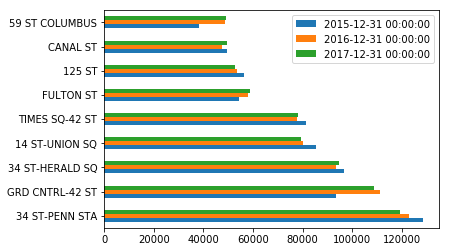

In [147]:
h=exits[1:10].iloc[::,:]
h.plot.barh(stacked=False)

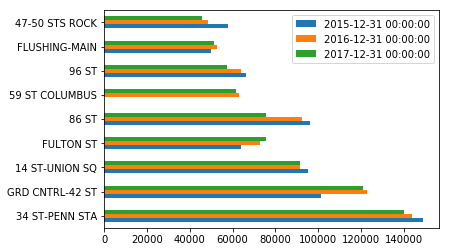

In [148]:
g=entries[1:10].iloc[::,:]
g.plot.barh(stacked=False)

In [151]:
exits[1:10]

,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00
34 ST-PENN STA,128635.138554,122934.383721,119316.596591
GRD CNTRL-42 ST,93606.833333,111130.393162,108811.965812
34 ST-HERALD SQ,96659.607143,93559.567867,94725.918033
14 ST-UNION SQ,85378.372372,80253.382682,79377.672316
TIMES SQ-42 ST,81286.500000,77895.271468,78260.274194
FULTON ST,54314.651007,58182.804560,58714.133333
125 ST,56355.334320,53651.136490,52753.547872
CANAL ST,49551.663690,47591.915730,49425.928571
59 ST COLUMBUS,38175.833333,48626.784530,49199.657609


In [152]:
entries[1:10]

,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00
34 ST-PENN STA,149071.595166,143881.507375,140003.386364
GRD CNTRL-42 ST,101522.166667,122739.721774,121015.732759
14 ST-UNION SQ,95154.146269,91720.553073,91474.500000
FULTON ST,63866.493902,72719.977591,75841.445714
86 ST,96031.550595,92626.237569,75545.899441
59 ST COLUMBUS,NaN,62793.449721,61688.731183
96 ST,66426.857143,63854.264045,57303.857923
FLUSHING-MAIN,49803.500000,52668.429752,51412.304813
47-50 STS ROCK,57669.200000,48572.557746,45842.409836
